In [ ]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow

In [14]:
import pandas as pd
import numpy as np
import sklearn
import re
import string
import seaborn as sn
import matplotlib.pyplot as plt
import torch

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [16]:
data = pd.read_csv('train.csv')
data = data.drop(columns=['id', 'keyword', 'location'])

print(data.head(5))

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1


In [17]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_at(text):
    at = re.compile(r'\@(\w+)')
    return at.sub(r'', text)

def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [18]:
def cleanTweets(data):
    text = data['text']
    text = text.apply(lambda x: remove_URL(x)) \
               .apply(lambda x: remove_html(x)) \
               .apply(lambda x: remove_emoji(x)) \
               .apply(lambda x: remove_at(x)) \
               .apply(lambda x: remove_punct(x))
    return text.to_numpy()

def obtainTargets(data):
    return data['target'].to_numpy()

In [19]:
X_data = cleanTweets(data)
y_data = obtainTargets(data)

print(X_data)
print(y_data)

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask Canada'
 'All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected'
 ... 'M194 0104 UTC5km S of Volcano Hawaii '
 'Police investigating after an ebike collided with a car in Little Portugal Ebike rider suffered serious nonlife threatening injuries'
 'The Latest More Homes Razed by Northern California Wildfire  ABC News ']
[1 1 1 ... 1 1 1]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

In [37]:
import keras
import tensorflow 

In [178]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

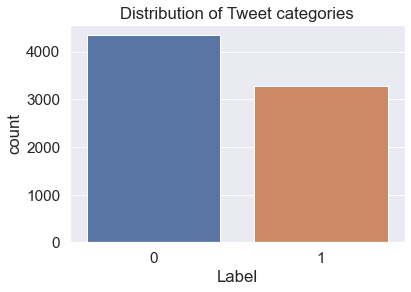

In [179]:
sn.countplot(x=y_data)
plt.xlabel('Label')
plt.title("Distribution of Tweet categories")
plt.show()

In [180]:
le = LabelEncoder()
Y = y_data
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [181]:
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [182]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [202]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.00004),metrics=['accuracy'])

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 embedding_27 (Embedding)    (None, 100, 50)           50000     
                                                                 
 lstm_27 (LSTM)              (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_45 (Activation)  (None, 256)               0         
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257

In [203]:
print(sequences_matrix)

[[  0   0   0 ... 338   1 550]
 [  0   0   0 ...  38  68 679]
 [  0   0   0 ...   1 680 440]
 ...
 [  0   0   0 ...   4 489 983]
 [  0   0   0 ... 111 755   5]
 [  0   0   0 ...   3 859 107]]


In [204]:
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs=100,
          validation_split=0.2,callbacks=[EarlyStopping(patience=3,monitor='val_loss')])

Epoch 1/100
39/39 [==============================] - 6s 107ms/step - loss: 0.6902 - accuracy: 0.5800 - val_loss: 0.6903 - val_accuracy: 0.5427
Epoch 2/100
39/39 [==============================] - 4s 95ms/step - loss: 0.6865 - accuracy: 0.5809 - val_loss: 0.6882 - val_accuracy: 0.5427
Epoch 3/100
39/39 [==============================] - 3s 89ms/step - loss: 0.6824 - accuracy: 0.5809 - val_loss: 0.6864 - val_accuracy: 0.5427
Epoch 4/100
39/39 [==============================] - 4s 96ms/step - loss: 0.6786 - accuracy: 0.5809 - val_loss: 0.6859 - val_accuracy: 0.5427
Epoch 5/100
39/39 [==============================] - 4s 101ms/step - loss: 0.6759 - accuracy: 0.5809 - val_loss: 0.6856 - val_accuracy: 0.5427
Epoch 6/100
39/39 [==============================] - 4s 97ms/step - loss: 0.6743 - accuracy: 0.5809 - val_loss: 0.6854 - val_accuracy: 0.5427
Epoch 7/100
39/39 [==============================] - 3s 87ms/step - loss: 0.6724 - accuracy: 0.5809 - val_loss: 0.6835 - val_accuracy: 0.5427
Epoc

In [205]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


In [206]:
accr = model.evaluate(test_sequences_matrix,y_test)

48/48 [==============================] - 1s 11ms/step - loss: 0.5089 - accuracy: 0.7702


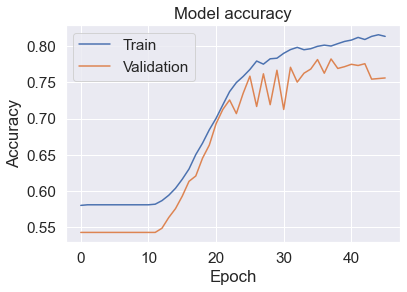

In [213]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

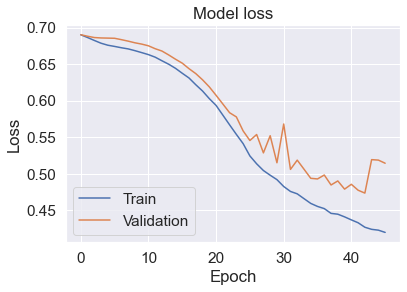

In [212]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train)
y = y_train

In [9]:
print(vectorizer.get_feature_names_out())
print(X.shape)

['001116' '0025' '005225' ... 'ûóher' 'ûókody' 'ûótech']
(6090, 13614)


In [10]:
logistic_regression_model = LogisticRegression(verbose=3, solver="saga").fit(X, y)

convergence after 22 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [11]:
print(logistic_regression_model.score(vectorizer.transform(X_test), y_test))

0.814182534471438


In [12]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(logistic_regression_model.predict(vectorizer.transform(X_test)), y_test).ravel()
cm = np.array([[tn, fp], [fn, tp]])
print(cm)

[[788 204]
 [ 79 452]]


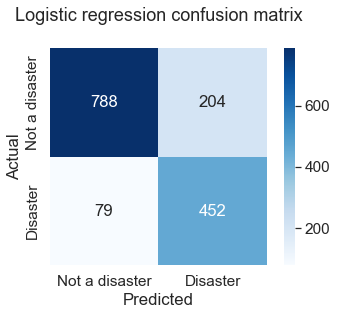

In [13]:
df_cm = pd.DataFrame(cm, ['Not a disaster', 'Disaster'], ['Not a disaster', 'Disaster'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, square="True", cmap="Blues", fmt="d")
plt.title("Logistic regression confusion matrix\n", fontsize=18)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()